In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from config import Config
from model import GPT2
import utils as u
from collect_data import LinRegData
from predictions import Ridge, oracle, DiscreteMMSE
from tqdm import tqdm

assert torch.cuda.is_available()
device = 'cuda'

config = Config()

/home/jovyan/mop4/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
run_ids = [
    # "lhuztt7a",
    "0nk3a4b3",
    "javn7bsd",
    "ycr0ep5j",
    "58es818e",
    "79tldc2i",
    "95tkac8y"
]
step = 524288
runs = {
    run_id: {
        "ckpt_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/{run_id}/checkpoints/epoch=0-step={step}.ckpt",
        "task_pool_path": f"/home/jovyan/data-diversity-reproduction/outputs/{run_id}_task_pool.pt"
    } for run_id in run_ids
}

In [3]:
for run_id, run in runs.items():
    task_pool = torch.load(run["task_pool_path"])
    run["task_pool_size"] = task_pool.shape[0]

run_ids = sorted(run_ids, key=lambda x: runs[x]["task_pool_size"])
task_pool_size = np.array([runs[run_id]["task_pool_size"] for run_id in run_ids])

In [4]:
for run_id, run in runs.items():
    model = GPT2.load_from_checkpoint(run["ckpt_path"], n_dims_in=config.dim+1, n_positions=config.n_points).eval().to(device)

    with torch.no_grad():
        linregdata = LinRegData(config, task_pool=torch.load(run["task_pool_path"]))
        data_iterator = linregdata.batch_generator(config.n_validation_batches)
        sq_errs = []
        for i, batch in enumerate(data_iterator):
            for k, v in batch.items():
                batch[k] = v.to(device)
            tf_preds = model(batch)
            oracle_preds = oracle(batch)
            sq_err = (tf_preds - oracle_preds)**2
            sq_errs.append(sq_err.mean(axis=1).cpu())
        sq_errs = np.concatenate(sq_errs).flatten()
        sq_errs_normalized = sq_errs/config.dim
        loss = sq_errs_normalized.mean()
        err_bar = (3/sq_errs_normalized.size) * np.std(sq_errs_normalized)

        run["loss"] = loss
        run["err_bar"] = err_bar

In [5]:
# run_id = "79tldc2i"
# run = runs[run_id]
# task_pool = torch.load(run["task_pool_path"])
# linregdata = LinRegData(config, task_pool=task_pool)
# batch = next(linregdata.batch_generator(1))

# ridge = Ridge(config.noise_scale)
# dmmse = DiscreteMMSE(task_pool, config.noise_scale)

In [6]:
model_names = ["Ridge", "DiscreteMMSE", "MOP", "Oracle"]

for run_id, run in runs.items():
    task_pool = torch.load(run["task_pool_path"])
    run["task_pool_size"] = task_pool.shape[0]

    models = {
        "Ridge": Ridge(config.noise_scale),
        "DiscreteMMSE": DiscreteMMSE(task_pool, config.noise_scale),
        "MOP": GPT2.load_from_checkpoint(run["ckpt_path"], n_dims_in=config.dim+1, n_positions=config.n_points).eval().to(device),
        "Oracle": oracle
    }

    with torch.no_grad():
        linregdata = LinRegData(config, task_pool=task_pool)
        data_iterator = linregdata.batch_generator(10)
        predictions = {k: [] for k in models}
        for i, batch in enumerate(data_iterator):
            for k, v in batch.items():
                batch[k] = v.to(device)
            for model_name, model in models.items():
                predictions[model_name].append(model(batch))
        for model_name in models:
            predictions[model_name] = torch.cat(predictions[model_name]).cpu()
        run["preds"] = predictions

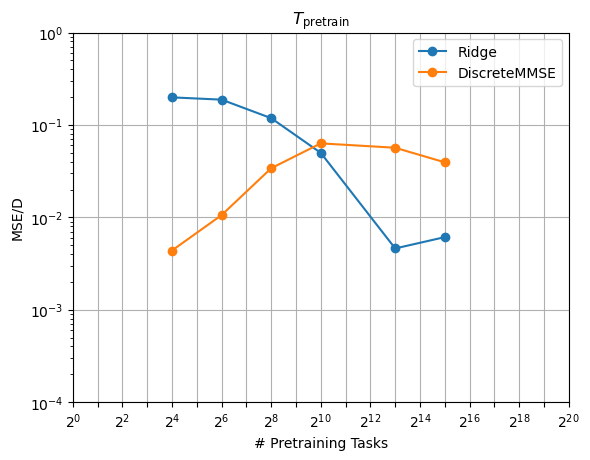

In [7]:
ridge_delta = [
    torch.mean((runs[run_id]["preds"]["MOP"] - runs[run_id]["preds"]["Ridge"])**2).numpy()/config.dim for run_id in run_ids
]
dmmse_delta = [
    torch.mean((runs[run_id]["preds"]["MOP"] - runs[run_id]["preds"]["DiscreteMMSE"])**2).numpy()/config.dim for run_id in run_ids
]

fig, ax = plt.subplots()
ax.loglog(task_pool_size, ridge_delta, marker='o', label='Ridge')
ax.loglog(task_pool_size, dmmse_delta, marker='o', label='DiscreteMMSE')

x_range = list(range(0,21))
x = [2**x for x in x_range]
ax.set_xticks(x, labels=[(f"$2^{{{x}}}$" if not x%2 else "") for x in x_range])
ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_ylim([1e-4,1])
ax.set_xlabel("# Pretraining Tasks")
ax.set_ylabel("MSE/D")
ax.grid()
ax.legend()
ax.set_title("$T_\\text{pretrain}$")
fig.show()

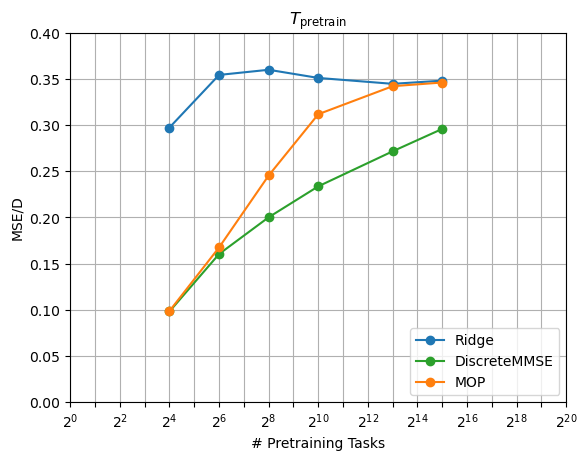

In [8]:
errors = [[
    torch.mean((runs[run_id]["preds"][model_name] - runs[run_id]["preds"]["Oracle"])**2).numpy()/config.dim for run_id in run_ids
] for model_name in model_names if model_name != "Oracle"]

fig, ax = plt.subplots()
colors = ['1f77b4', '2ca02c', 'ff7f0e', 'd62728', '9467bd', '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
for i, model_name in enumerate([model_name for model_name in model_names if model_name != "Oracle"]):
    ax.semilogx(task_pool_size, errors[i], label=model_name, marker='o', color="#"+colors[i])

x_range = list(range(0,21))
x = [2**x for x in x_range]
ax.set_xticks(x, labels=[(f"$2^{{{x}}}$" if not x%2 else "") for x in x_range])
ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_ylim([0,0.4])
ax.set_xlabel("# Pretraining Tasks")
ax.set_ylabel("MSE/D")
ax.grid()
ax.legend(loc='lower right')
ax.set_title("$T_\\text{pretrain}$")
fig.show()